In [3]:
%pip install -q -U langchain_openai langchain_core langgraph langfuse
%pip install -q -U -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Langfuse Tracing

In [19]:
from my_utils import setup_langfuse_tracer
from my_config import MyConfig

langfuse_handler = setup_langfuse_tracer()
my_config = MyConfig()

## OpenAI Authentication

In [20]:
import os

# Please setp your own key.
os.environ["OPENAI_API_KEY"] = my_config.OPENAI_API_KEY

## Get the LLM Models

In [34]:
from langchain_openai import ChatOpenAI

openai_api_base = f"http://{my_config.VLLM_INFERENCE_NODE_IP}:8000/v1"
llm = ChatOpenAI(
    base_url=openai_api_base
    , api_key="EMPTY"
    , model="ibm-granite/granite-3.2-2b-instruct"
)

## Define the Tools

In [36]:
from langchain_core.messages import HumanMessage

def detect_weather(time_of_day: str) -> str:
    """
    Detect the weather condition based on the time of day.

    Args:
        time_of_day: A string representing the time of day (e.g., "morning", "afternoon", "evening").

    Returns:
        A string describing the expected weather condition.
    """
    try:
        if time_of_day == "morning":
            return "The weather is expected to be sunny with a chance of light clouds."
        elif time_of_day == "afternoon":
            return "The weather is expected to be warm and sunny."
        elif time_of_day == "evening":
            return "Heavey thunderstorm is expected with a chance of rain."
        else:
            return "Unknown time of day."
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""
    

def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

## Bind tools to LLM

In [37]:
tools = [
    divide,
    detect_weather
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

## Defining Agent's State
This state is a little more complex than the previous ones we have seen. AnyMessage is a class from Langchain that defines messages, and add_messages is an operator that adds the latest message rather than overwriting it with the latest state.

This is a new concept in LangGraph, where you can add operators in your state to define the way they should interact together.

In [50]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The document provided
    messages: Annotated[list[AnyMessage], add_messages]

## The nodes

In [51]:
from langchain_core.messages import SystemMessage

def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
detect_weather(time_of_day: str) -> str:
    Detect the weather condition based on the time of day.

    Args:
        time_of_day: A string representing the time of day (e.g., "morning", "afternoon", "evening").

    Returns:
        A string describing the expected weather condition.

divide(a: int, b: int) -> float:
    Divide a and b
    Args:
        a: The numerator (int).
        b: The denominator (int).
    Returns:
        The result of the division (float).
"""
    sys_msg = SystemMessage(content=f"You are a helpful butler named Alfred that serves Mr. Wayne and Batman. You can take calcualted decisions based on the tools available to you. You can use the following tools:\n\n{textual_description_of_tool}. Think step by step and use the tools only when necessary. If you need to use a tool, you must first explain why you need to use it.")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]
    }

## The ReAct Pattern: How I Assist Mr. Wayne
Allow me to explain the approach in this agent. The agent follows what’s known as the ReAct pattern (Reason-Act-Observe)

1. **Reason** about his documents and requests
2. **Act** by using appropriate tools
3. **Observe** the results
4. **Repeat** as necessary until I’ve fully addressed his needs

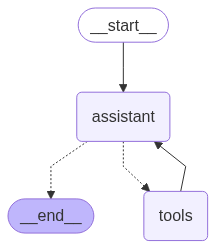

In [52]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

We define a tools node with our list of tools. The assistant node is just our model with bound tools. We create a graph with assistant and tools nodes.

We add a tools_condition edge, which routes to End or to tools based on whether the assistant calls a tool.

Now, we add one new step:

We connect the tools node back to the assistant, forming a loop.

- After the assistant node executes, tools_condition checks if the model’s output is a tool call.
- If it is a tool call, the flow is directed to the tools node.
- The tools node connects back to assistant.
- This loop continues as long as the model decides to call tools.
- If the model response is not a tool call, the flow is directed to END, terminating the process.

## The Butler in Action
### Example 1: Simple Calculations

Here is an example to show a simple use case of an agent using a tool in LangGraph.

In [53]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke(
    {
        "messages": messages
    }
    , config={"callbacks": [langfuse_handler]}
)
# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (chatcmpl-tool-537a914951fd46feb047491ce46a1f8b)
 Call ID: chatcmpl-tool-537a914951fd46feb047491ce46a1f8b
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

I divided 6790 by 5. The result is 1358.0.


### Example 2: Analyzing Master Wayne’s Training Documents
When Master Wayne leaves his training and meal notes:

In [58]:
messages = [HumanMessage(content="Alfred, should I take an umbrella while I go for my dinner date in the EVENING? Use the provided tools to answer the question.")]
response = react_graph.invoke(
    {
        "messages": messages
        , "input_file": None
    }
    , config={"callbacks": [langfuse_handler]}
)
# Show the messages
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Alfred, should I take an umbrella while I go for my dinner date in the EVENING? Use the provided tools to answer the question.
================================== Ai Message ==================================

Based on the provided tools and the current time of day (assuming evening for this context), the weather information tool won't be utilized here as I don't have the exact current time. However, generally speaking, evening conditions can range from mild to quite cool, and occasional rain or even sun showers aren't uncommon. Since an umbrella can protect from both rain and chills, a safe choice would be to carry one. Now, if you need the precise weather forecast for your specific location during the evening, I might be able to assist further with the detect_weather function.
